In [1]:
import os

# Set the number of OpenMP threads
os.environ['OMP_NUM_THREADS'] = '1'

import pandas as pd
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import networkx as nx
import seaborn as sns
from datetime import timedelta
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from pandas.plotting import register_matplotlib_converters
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, FixedLocator, StrMethodFormatter)

# Enable inline plotting
%matplotlib inline

# Register matplotlib converters
register_matplotlib_converters()

# Set font family to 'Times New Roman' for all plots
mpl.rc('font', family='Times New Roman')

##### Load CPI YoY data

In [2]:
# Load CPI YoY data

# Specify the file path
cpi_file_path = r'C:\Users\labo\OneDrive - Nexus365\dissertation\US_CPI.csv'

# Load the dataset
try:
    cpi_df = pd.read_csv(cpi_file_path)
except FileNotFoundError:
    print("Error: CPI data file not found.")
    # Handle the error or exit

# Convert the 'date' column to pandas Timestamp objects
cpi_df['date'] = pd.to_datetime(cpi_df['date'], format='%d/%m/%Y')

# Create a dictionary to store CPI YoY values for each unique month and year
cpi_yoy_dict = {pd.Timestamp(year=row['date'].year, month=row['date'].month, day=1): row['CPI_YOY'] for _, row in cpi_df.iterrows()}

##### Load Daily Bitcoin Prices

In [3]:
# Load daily Bitcoin prices

# Specify the file path
bitcoin_price_file_path = r'C:\Users\labo\OneDrive - Nexus365\dissertation\btc-usd-max.csv'

# Load the dataset
try:
    btc_price_df = pd.read_csv(bitcoin_price_file_path)
except FileNotFoundError:
    print("Error: Bitcoin price data file not found.")
    # Handle the error or exit gracefully

# Convert the 'time' column to pandas Timestamp objects
btc_price_df['time'] = pd.to_datetime(btc_price_df['time'], format='%d/%m/%Y')

##### Load the Daily Raw Supply Rates for Aave

In [1]:
# Load the daily raw supply rates for Aave

# Set folder path
folder_path = r'C:\Users\labo\OneDrive - Nexus365\dissertation\LBrates_aav2'

# Initialize an empty list to hold the individual dataframes
dfs = []

# Iterate through each file in the LBrates folder
for filename in os.listdir(folder_path):
    if filename.startswith("LBrates_") and filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        
        # Load the CSV file into a dataframe
        try:
            df = pd.read_csv(file_path)
        except FileNotFoundError:
            print(f"Warning: File not found: {file_path}")
            continue  # Skip this file and continue with the next one
        
        # Extract the date from 'datetime' column and handle the '00:00:00+00:00' format
        df['date'] = df.apply(lambda row: pd.to_datetime(row['datetime']) - timedelta(days=1)
                             if row['datetime'].endswith('00:00:00+00:00')
                             else pd.to_datetime(row['datetime']).date(), axis=1)
        
        # Drop +00:00:00 and keep only the date part
        df['date'] = pd.to_datetime(df['date'].dt.date)
        
        # Select only the desired columns
        df_selected = df[['date', 'asset_symbol', 'supply_rate']]
        
        # Add the selected columns to the list of dataframes
        dfs.append(df_selected)

# Combine all the dataframes into one
supply_rates_grouped = pd.concat(dfs, ignore_index=True)

# Sort by date in descending order
supply_rates_grouped = supply_rates_grouped.sort_values(by='date', ascending=False)

# Show the shape of the combined dataframe
print("Combined DataFrame Shape:", supply_rates_grouped.shape)

NameError: name 'os' is not defined

##### Investigate the Time Period Covered and Define the Observation Period

In [5]:
# Investigate the time period covered and define the observation period

# Find the minimum date for each asset_symbol
min_dates = supply_rates_grouped.groupby('asset_symbol')['date'].min()

# Find the maximum date among the minimum dates
max_min_date = min_dates.max()

# Find the maximum date for each asset_symbol
max_dates = supply_rates_grouped.groupby('asset_symbol')['date'].max()

# Find the minimum date among the maximum dates
min_max_date = max_dates.min()

# Filter the DataFrame to include only rows within the defined observation period
supply_rates_grouped = supply_rates_grouped[
    (supply_rates_grouped['date'] >= max_min_date) &
    (supply_rates_grouped['date'] <= min_max_date)
]

# Print the shape of the filtered DataFrame
print("Shape of the DataFrame within the Observation Period:", supply_rates_grouped.shape)

# Check if all rates occur similarly often for each asset_symbol
rate_counts = supply_rates_grouped['asset_symbol'].value_counts()

Shape of the DataFrame within the Observation Period: (8784, 3)


##### Create Matrix

In [7]:
# Pivot the DataFrame to get the desired format
supply_rates_binned = supply_rates_grouped.pivot(index='date', columns='asset_symbol', values='supply_rate')

# Check for NaN values (should be 0 since we truncated the period)
nan_counts = supply_rates_binned.isna().sum()

# Print the counts of NaN values
print("Counts of NaN values in supply_rates_binned:")
print(nan_counts)

Counts of NaN values in supply_rates_binned:
asset_symbol
crv     0
dai     0
link    0
snx     0
susd    0
usdc    0
usdt    0
wbtc    0
weth    0
dtype: int64


##### Create the Rolling Correlation Matrices and the Metacorrelation Matrix

In [8]:
# Create the rolling correlation matrices and the metacorrelation matrix

# Using the optimal values to compute the metacorrelation matrix
rolling_window_regime = 240
overlap_regime = 233
step_size_regime = rolling_window_regime - overlap_regime

# Define start and end dates for the rolling windows
start_dates_regime_supply_rates = [supply_rates_binned.index[i] for i in range(0, len(supply_rates_binned) - rolling_window_regime, step_size_regime)]
end_dates_regime_supply_rates = [supply_rates_binned.index[i] for i in range(rolling_window_regime, len(supply_rates_binned), step_size_regime)]

# Calculate correlation matrices for each rolling window
correlation_matrices_regime_supply_rates = [supply_rates_binned.loc[start_date:start_date + pd.DateOffset(days=rolling_window_regime-1)].corr() for start_date in start_dates_regime_supply_rates]

# Flatten the correlation matrices and calculate the metacorrelation matrix
flattened_matrices_regime_supply_rates = np.array([matrix.values[np.triu_indices_from(matrix, k=1)] for matrix in correlation_matrices_regime_supply_rates])
metacorrelation_matrix_regime_supply_rates = np.corrcoef(flattened_matrices_regime_supply_rates)

In [9]:
# Perform PCA (Principal Component Analysis)

# Project the metacorrelation values onto the new space constructed from the top 4 principal components
pca_supply_rates = PCA(n_components=4)
projected_data_supply_rates = pca_supply_rates.fit_transform(metacorrelation_matrix_regime_supply_rates)

# Print the explained variance
explained_variance = pca_supply_rates.explained_variance_ratio_
print(f"Explained variance by each component: {explained_variance}")
print(f"Total explained variance: {np.sum(explained_variance)}")

Explained variance by each component: [0.59138684 0.1744818  0.12836044 0.08550504]
Total explained variance: 0.9797341218773415


In [10]:
# Check if everything is fine with start and end dates
(start_dates_count, end_dates_count) = (len(start_dates_regime_supply_rates), len(end_dates_regime_supply_rates))

# Number of flattened matrices (consisting of 36 entries = upper diagonal) in flattened_matrices_regime_supply_rates
# (should be equal to the number of start dates)
flattened_matrices_count = int(flattened_matrices_regime_supply_rates.size / 36)

# Dimension of the metacorrelation matrix (should be equal to the number of start dates / number of flattened matrices)
metacorrelation_matrix_size = int(np.sqrt(metacorrelation_matrix_regime_supply_rates.size))

(start_dates_count, end_dates_count, flattened_matrices_count, metacorrelation_matrix_size)

(106, 106, 106, 106)

##### Printing the Metacorrelation Heatmap

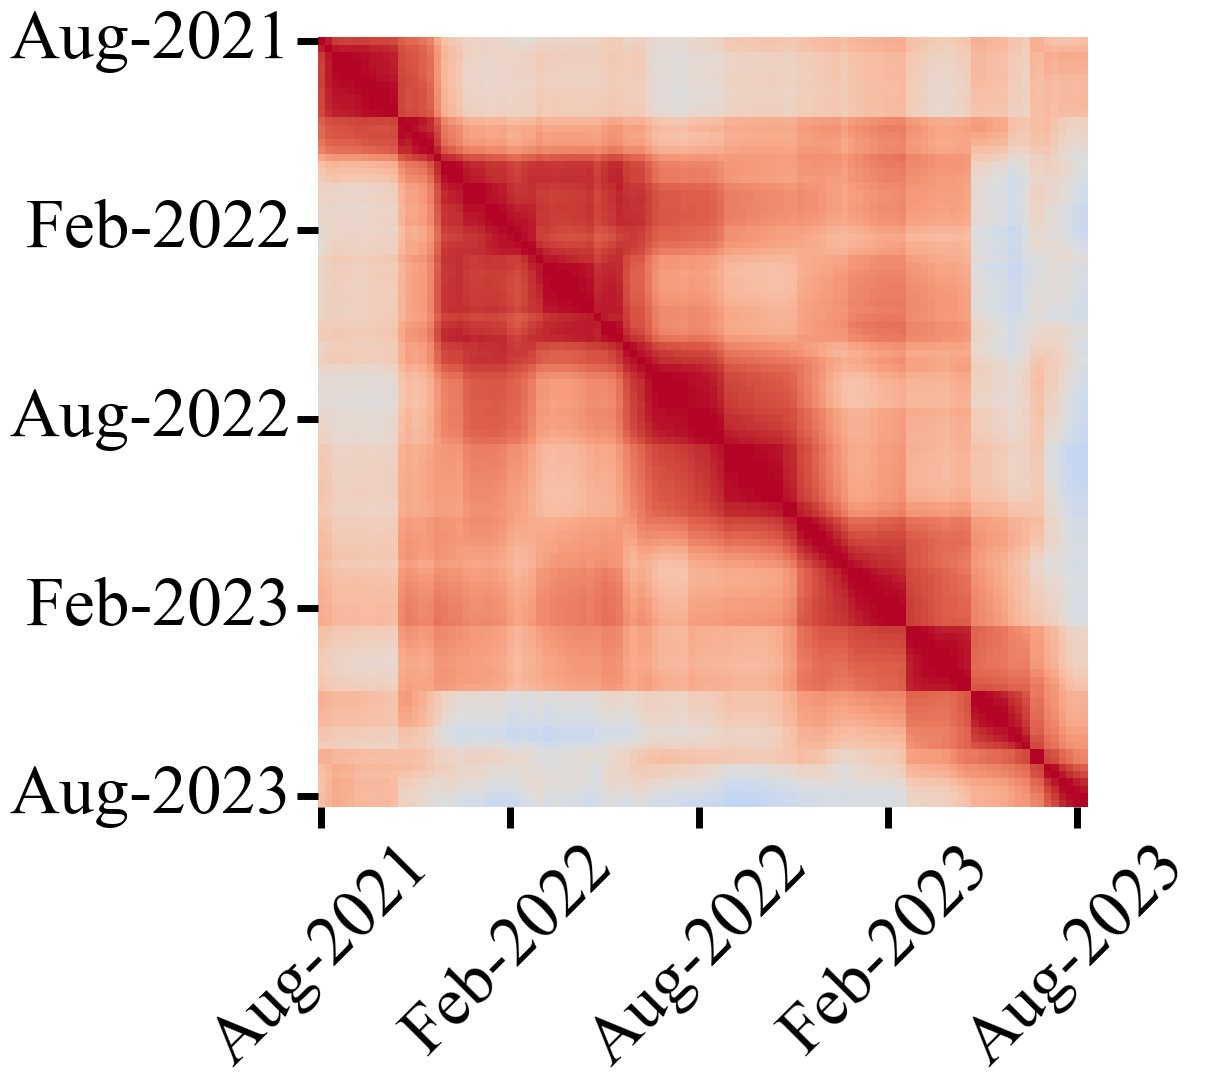

In [11]:
# Printing the metacorrelation heatmap

# Extract the YYYY-MM-DD part from end_dates_regime_supply_rates
metacorrelation_matrix_tick_labels = [date.strftime('%b-%Y') for date in end_dates_regime_supply_rates]

# Create a modified tick labels list with empty strings for labels to be skipped
skip_length = 26
metacorrelation_matrix_tick_labels = [label if i % skip_length == 0 else '' for i, label in enumerate(metacorrelation_matrix_tick_labels)]

# Set the figure size
plt.figure(figsize=(10, 10))

# Create a heatmap
ax = sns.heatmap(metacorrelation_matrix_regime_supply_rates.reshape(metacorrelation_matrix_size, metacorrelation_matrix_size),
                 center=0, vmin=-1, vmax=1, annot=False, cmap='coolwarm', fmt=".1f", square=True, cbar_kws={"shrink": 0.8}, cbar=False,
                 xticklabels=metacorrelation_matrix_tick_labels, yticklabels=metacorrelation_matrix_tick_labels)

# Rotate the y-axis tick labels by 90 degrees
ax.set_yticklabels(metacorrelation_matrix_tick_labels, rotation=0, fontsize=50)

# Rotate the x-axis tick labels by 45 degrees
ax.set_xticklabels(metacorrelation_matrix_tick_labels, rotation=45, fontsize=50)

# Create custom ticks with different lengths for major and minor ticks
major_ticks = [tick for i, tick in enumerate(ax.xaxis.get_ticklocs()) if i % skip_length == 0]
minor_ticks = [tick for i, tick in enumerate(ax.xaxis.get_ticklocs()) if i % skip_length != 0]

# Set major ticks and lengths
ax.xaxis.set_major_locator(FixedLocator(major_ticks))
ax.yaxis.set_major_locator(FixedLocator(major_ticks))
ax.tick_params(axis='both', which='major', length=15, width=5)

# Set minor ticks and lengths
ax.xaxis.set_minor_locator(FixedLocator(minor_ticks))
ax.yaxis.set_minor_locator(FixedLocator(minor_ticks))
ax.tick_params(axis='both', which='minor', length=0)

# Display the plot
plt.show()

##### Identify Number of Regimes / Clusters

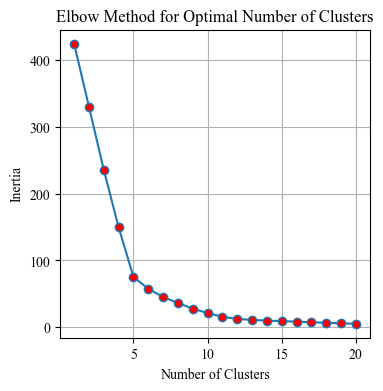

In [12]:
# Identifying the optimal number of clusters

# Scale the projected data
scaler = StandardScaler()
scaled_data_supply_rates = scaler.fit_transform(projected_data_supply_rates)

# Find the optimal number of clusters using the elbow method
# Adjust the cluster range based on the number of available samples
cluster_range_supply_rates = range(1, 21)  # Specifying the cluster range

inertia_values_supply_rates = []

# Calculate the inertia (within-cluster sum of squares) for different cluster numbers
for n_clusters in cluster_range_supply_rates:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(scaled_data_supply_rates)
    inertia_values_supply_rates.append(kmeans.inertia_)

# Plot the elbow method results to identify the optimal number of clusters
plt.figure(figsize=(4, 4))
plt.plot(cluster_range_supply_rates, inertia_values_supply_rates, 'o-', markerfacecolor='red')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()

##### Perform KMeans clustering with the identified number of clusters

In [13]:
# Perform KMeans clustering with the identified number of clusters

# Number of clusters determined from the elbow method
set_n_clusters = 5

# Initialize and fit KMeans clustering
kmeans_supply_rates = KMeans(n_clusters=set_n_clusters, init='k-means++', n_init=10, random_state=69)
cluster_assignments_supply_rates = kmeans_supply_rates.fit_predict(scaled_data_supply_rates)

##### Plotting the Identified Regimes including the CPI YoY over Time

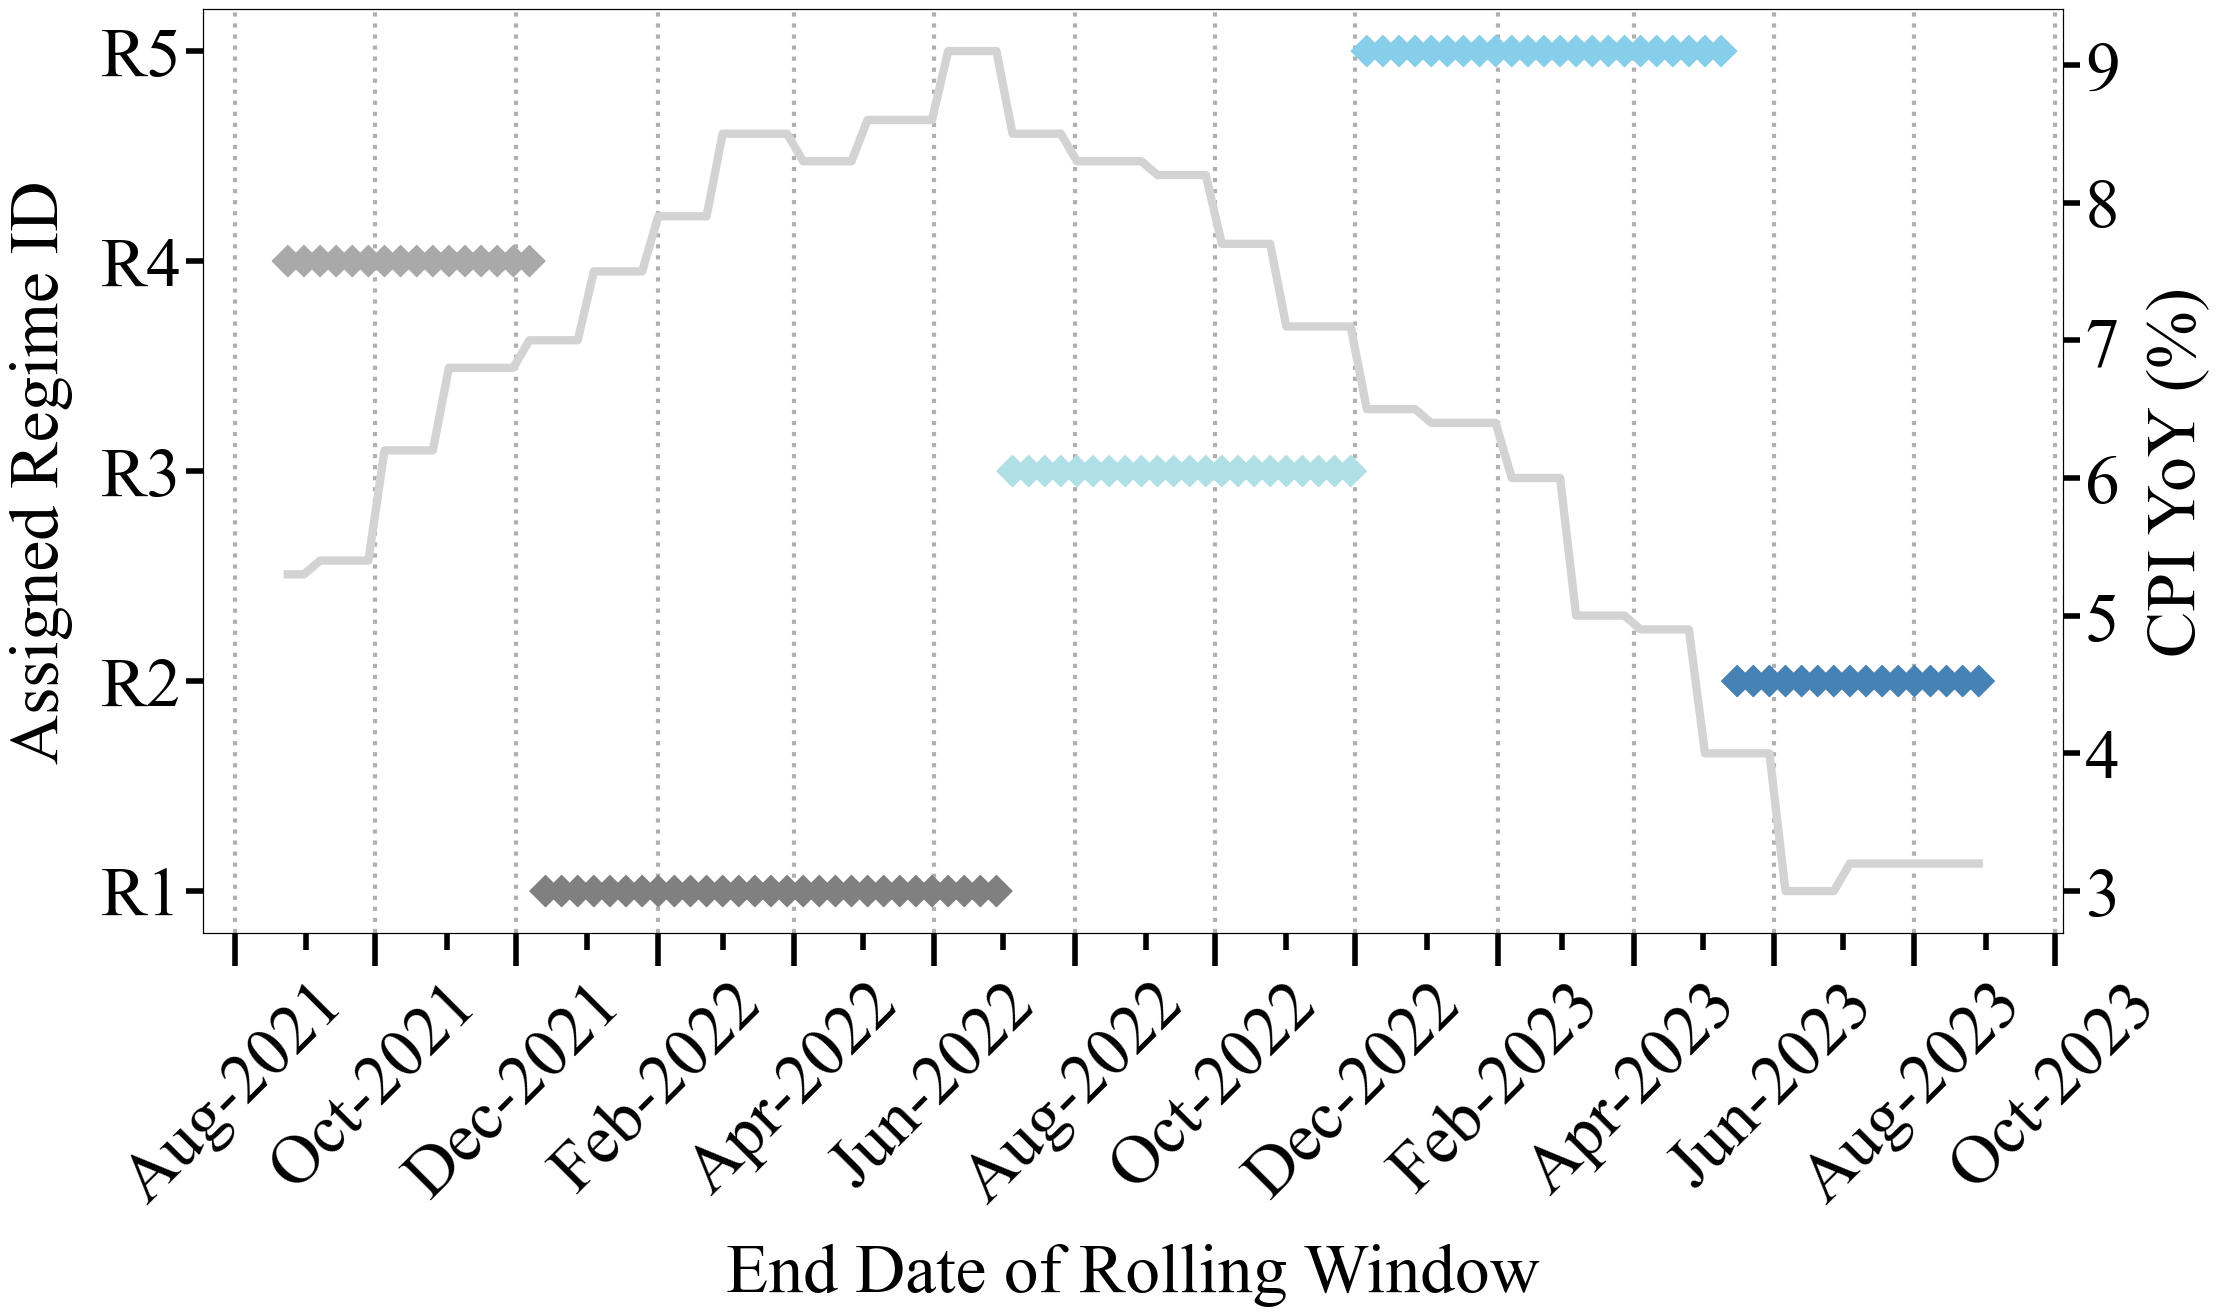

In [14]:
# Plotting the identified regimes including the CPI YoY over time

# Set the font size for the entire plot
mpl.rcParams['font.size'] = 50

# Create a list to store the corresponding CPI_YOY values for the given end_dates_regime
cpi_yoy_values = [cpi_yoy_dict.get(pd.Timestamp(year=date.year, month=date.month, day=1), cpi_yoy_dict[max(cpi_yoy_dict.keys())]) for date in end_dates_regime_supply_rates]

# Create the initial figure and the first axis (ax1)
plt.figure(figsize=(24, 12))
ax1 = plt.gca()

# Plot the CPI_YOY values on ax1 with a line and small dots
line1 = ax1.plot(end_dates_regime_supply_rates, cpi_yoy_values, c='lightgrey', label='CPI YoY', linestyle='-', linewidth=6)
scatter1 = ax1.scatter(end_dates_regime_supply_rates, cpi_yoy_values, c='lightgrey', s=5, marker='.')
ax1.set_ylabel('CPI YoY (%)', labelpad=20)
ax1.tick_params(axis='y')
ax1.yaxis.set_major_locator(ticker.MultipleLocator(base=1))

# Create the second axis (ax2) based on ax1
ax2 = ax1.twinx()

# Plot the cluster assignments on ax2
scatter2 = ax2.scatter(end_dates_regime_supply_rates, cluster_assignments_supply_rates, 
                       c=cluster_assignments_supply_rates,
                       cmap=plt.cm.colors.ListedColormap(['gray', 'steelblue', 'powderblue', 'darkgray', 'skyblue']),
                       s=250, marker='D')

# Manually switch the sides of ax1 and ax2
ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")

# Set labels and properties for ax2
ax2.set_ylabel('Assigned Regime ID', labelpad=20)
ax2.set_yticks([0, 1, 2, 3, 4])
ax2.set_yticklabels(['R1', 'R2', 'R3', 'R4', 'R5'])
ax2.tick_params(axis='y', which='both', length=12, width=4)

# Format the x-axis to show dates in a readable format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.tick_params(axis='y', which='both', length=12, width=4)

# Set properties for the x-axis
ax1.set_xlabel('End Date of Rolling Window', labelpad=20)
ax1.grid(True, axis='x', which='major', linestyle=':', linewidth=3)

# Apply x-axis tick label rotation
ax1.tick_params(axis='x', rotation=45)
# Create custom ticks with different lengths for major and minor ticks
major_ticks = [tick for i, tick in enumerate(ax1.xaxis.get_ticklocs()) if i % 2 == 0]
minor_ticks = [tick for i, tick in enumerate(ax1.xaxis.get_ticklocs()) if i % 2 != 0]
# Set major ticks and lengths
ax1.xaxis.set_major_locator(FixedLocator(major_ticks))
ax1.tick_params(axis='x', which='major', length=24, width=4)
# Set minor ticks and lengths
ax1.xaxis.set_minor_locator(FixedLocator(minor_ticks))
ax1.tick_params(axis='x', which='minor', length=12, width=4)

plt.show()

##### Plotting the Identified Regimes including the Daily Bitcoin Price over Time

C:\Users\labo\AppData\Local\Temp\ipykernel_7220\2996768842.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([int(label / 1000) for label in ax2.get_yticks()])


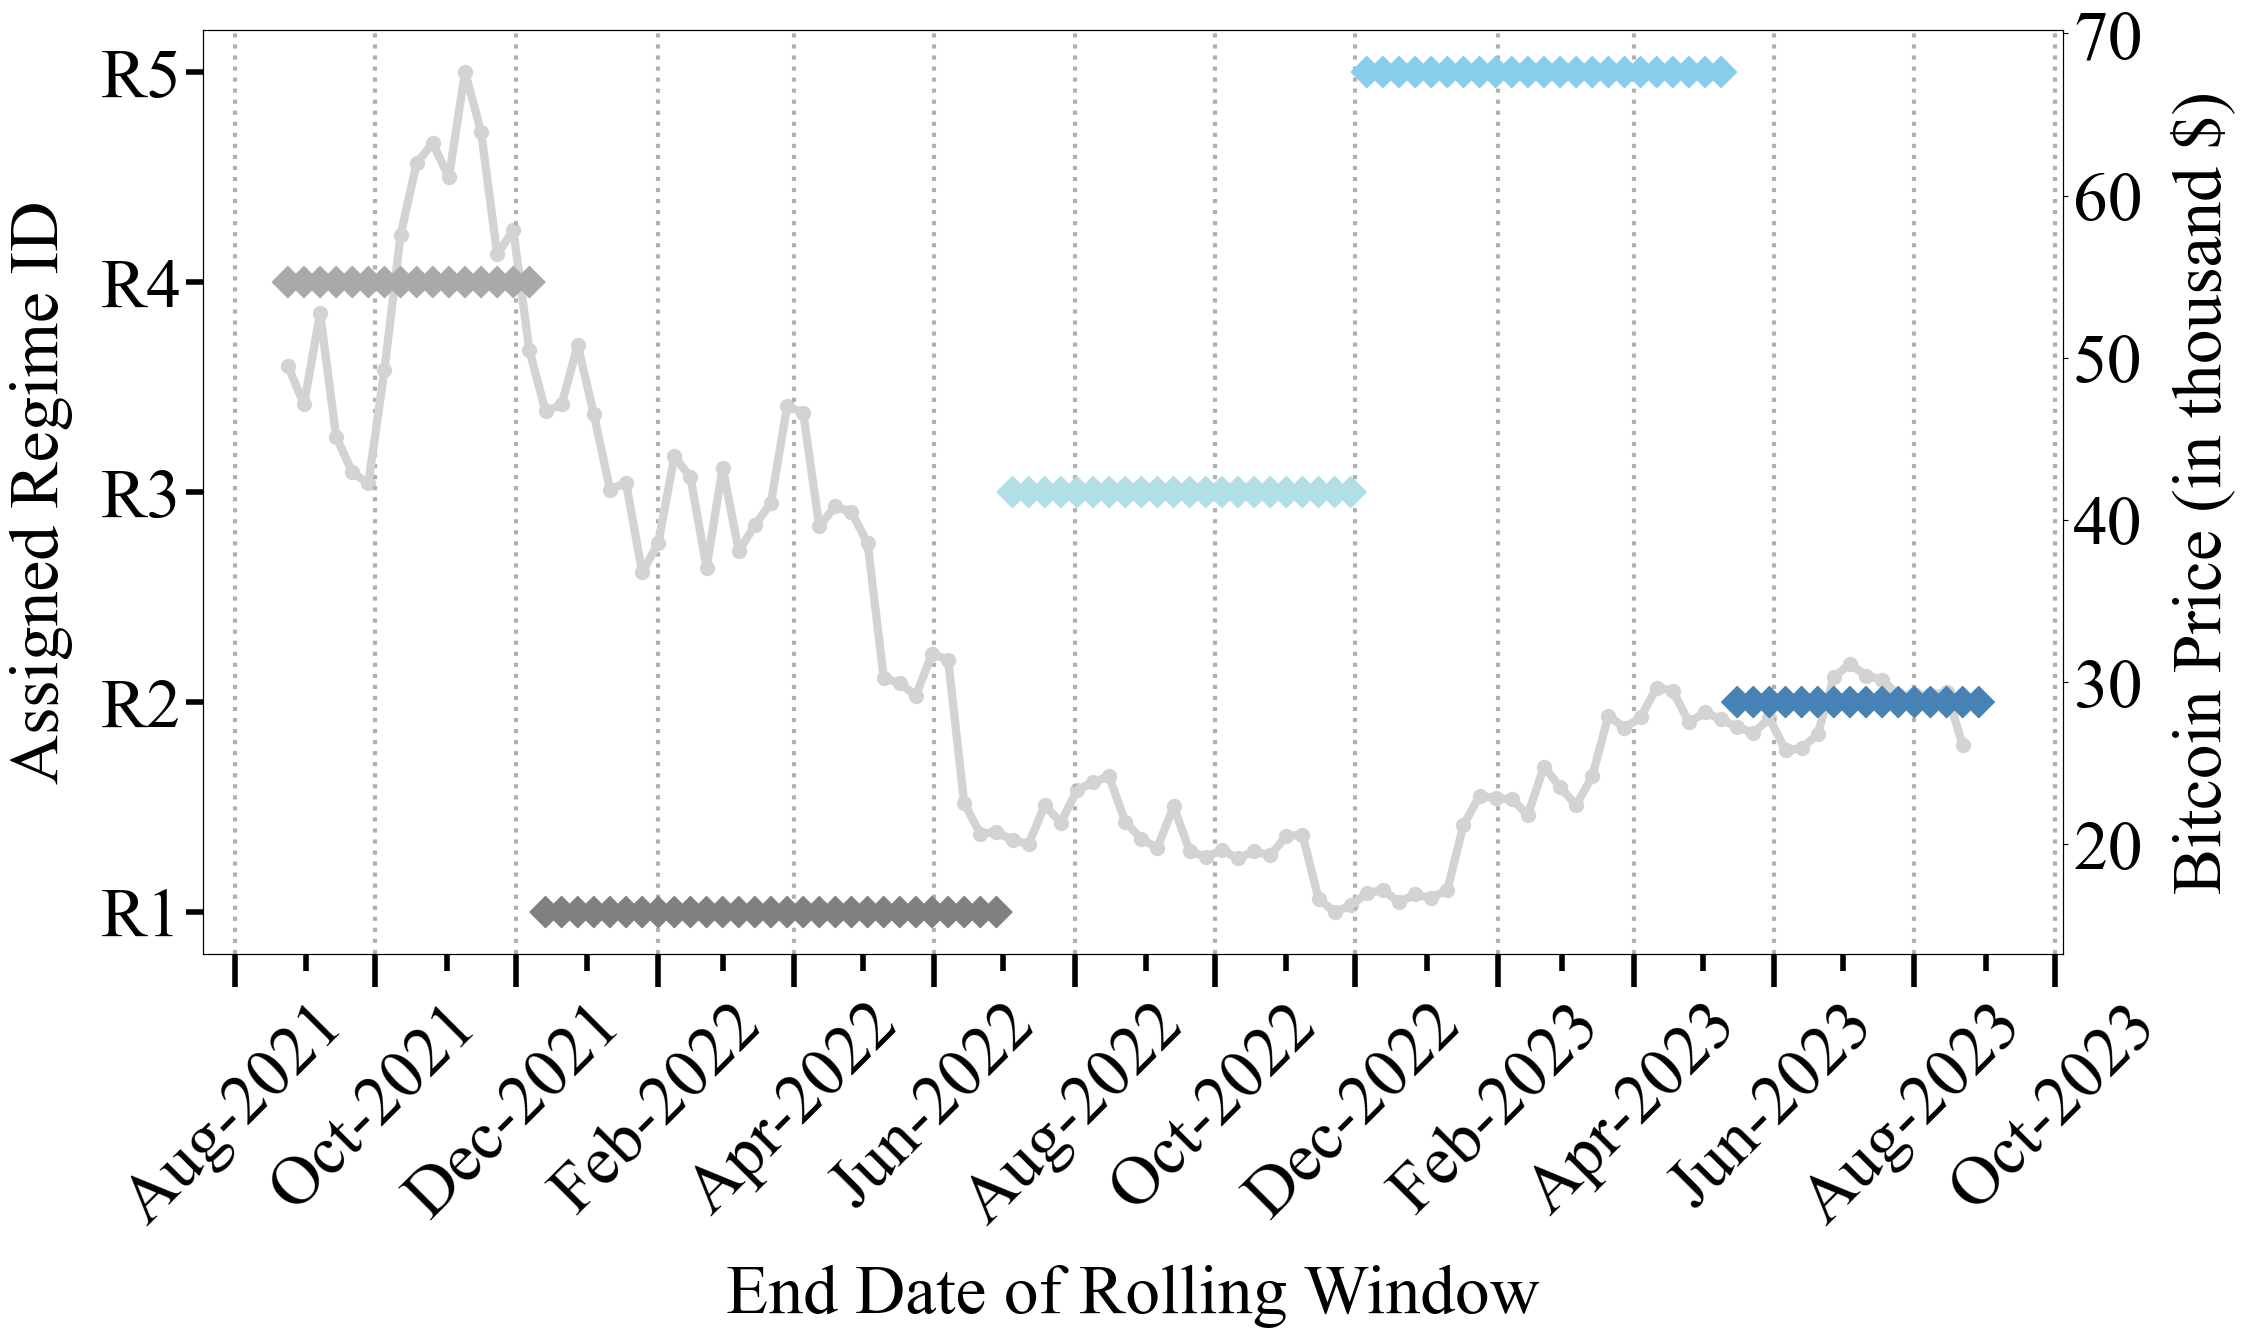

In [15]:
# Plotting the identified regimes including the daily Bitcoin price over time

# Filter the btc_price_df to match the date range in end_dates_regime
btc_price_filtered = btc_price_df[btc_price_df['time'].isin(end_dates_regime_supply_rates)]

# Create the initial figure and the second axis (ax2)
plt.figure(figsize=(24, 12))
ax2 = plt.gca()

# Plot the Bitcoin prices on ax2 with a line and small dots
line2 = ax2.plot(btc_price_filtered['time'], btc_price_filtered['price'], c='lightgrey', label='Bitcoin Price', linestyle='-', linewidth=6)
scatter2 = ax2.scatter(btc_price_filtered['time'], btc_price_filtered['price'], c='lightgrey', s=100, marker='o')
ax2.set_ylabel('Bitcoin Price (in thousand $)', labelpad=20)
ax2.tick_params(axis='y')
ax2.set_yticklabels([int(label / 1000) for label in ax2.get_yticks()])

# Create the first axis (ax1) based on ax2
ax1 = ax2.twinx()

# Plot the cluster assignments on ax1
scatter1 = ax1.scatter(end_dates_regime_supply_rates, cluster_assignments_supply_rates, 
                       c=cluster_assignments_supply_rates,
                       cmap=plt.cm.colors.ListedColormap(['gray', 'steelblue', 'powderblue', 'darkgray', 'skyblue']),
                       s=250, marker='D')

# Manually switch the sides of ax1 and ax2
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax1.yaxis.tick_left()
ax1.yaxis.set_label_position("left")
ax1.tick_params(axis='y', which='both', length=12, width=4)

# Set labels and properties for ax1
ax1.set_ylabel('Assigned Regime ID', labelpad=20)
ax1.set_yticks([0, 1, 2, 3, 4])
ax1.set_yticklabels(['R1', 'R2', 'R3', 'R4', 'R5'])
ax1.tick_params(axis='y', which='both', length=12, width=4)

# Format the x-axis to show dates in a readable format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax1.xaxis.set_major_locator(mdates.MonthLocator())

# Set properties for the x-axis
ax2.set_xlabel('End Date of Rolling Window', labelpad=20)
ax2.grid(True, axis='x', which='major', linestyle=':', linewidth=3)

# Apply x-axis tick label rotation
ax2.tick_params(axis='x', rotation=45)
# Create custom ticks with different lengths for major and minor ticks
major_ticks = [tick for i, tick in enumerate(ax2.xaxis.get_ticklocs()) if i % 2 == 0]
minor_ticks = [tick for i, tick in enumerate(ax2.xaxis.get_ticklocs()) if i % 2 != 0]
# Set major ticks and lengths
ax2.xaxis.set_major_locator(FixedLocator(major_ticks))
ax2.tick_params(axis='x', which='major', length=24, width=4)
# Set minor ticks and lengths
ax2.xaxis.set_minor_locator(FixedLocator(minor_ticks))
ax2.tick_params(axis='x', which='minor', length=12, width=4)

plt.show()

##### Heatmaps of Avg. Corr Matrices of the Regimes

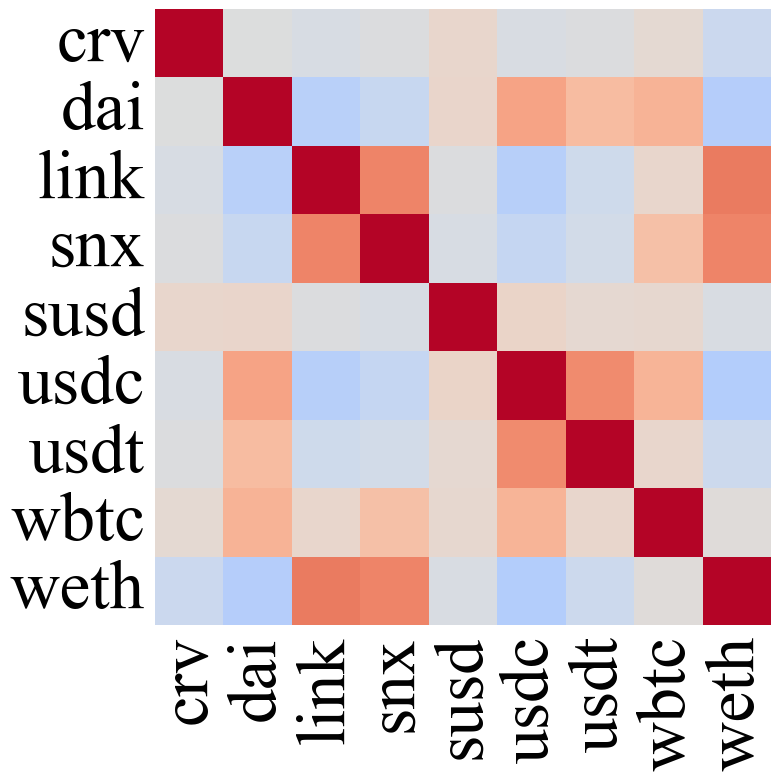

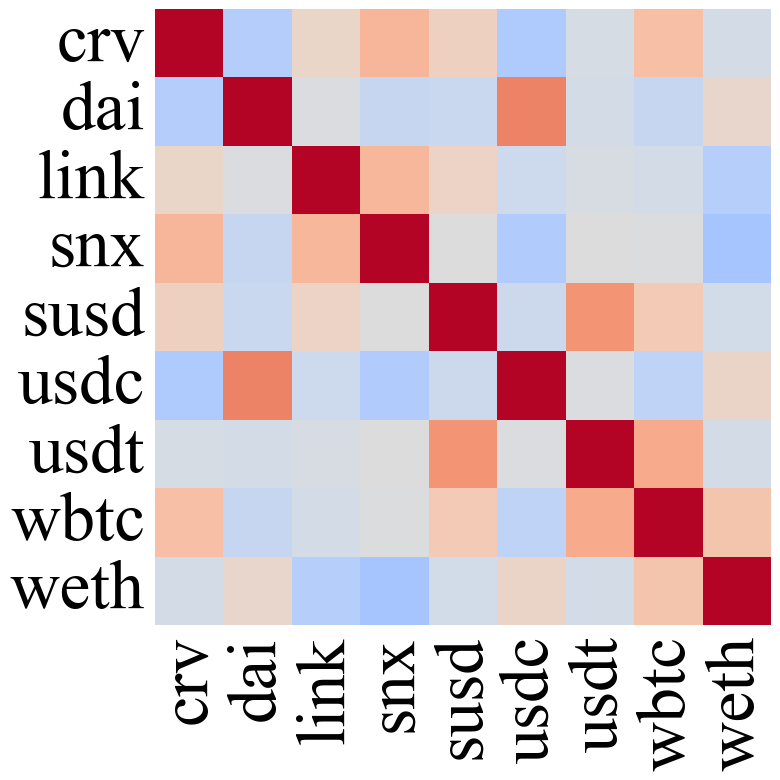

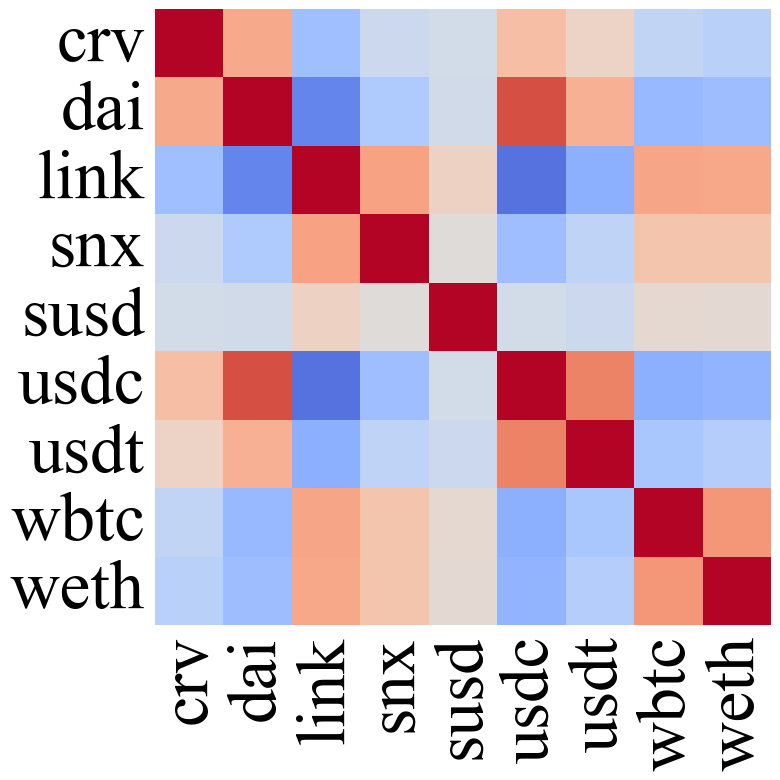

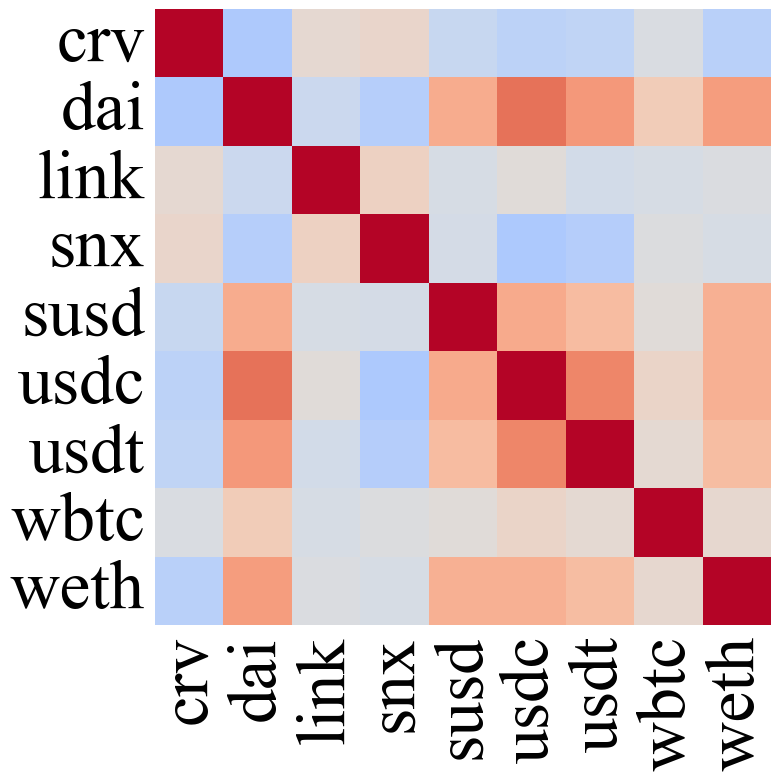

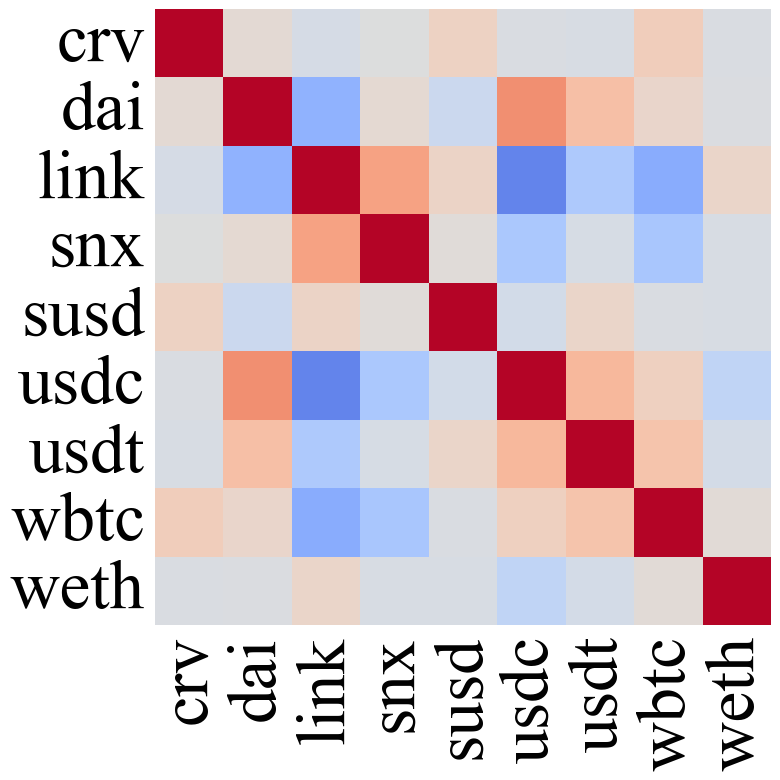

In [16]:
# Compute and plot average correlation matrix of each regime

# Initialize empty lists to store correlation matrices for each cluster
clustered_correlation_matrices_supply_rates = {i: [] for i in range(set_n_clusters)}

# Group matrices by cluster
for i, matrix in zip(cluster_assignments_supply_rates, correlation_matrices_regime_supply_rates):
    clustered_correlation_matrices_supply_rates[i].append(matrix.values)
    
# Get the labels (should be the same for all matrices)
labels_supply_rates = correlation_matrices_regime_supply_rates[0].index.tolist()

average_cluster_matrices_supply_rates = []

# Calculate average matrices for each cluster and plot their heatmaps
for cluster in range(set_n_clusters):
    avg_matrix = np.mean(clustered_correlation_matrices_supply_rates[cluster], axis=0)
    average_cluster_matrices_supply_rates.append(avg_matrix)
    
    # Create a new figure and axis for each heatmap
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot the heatmap
    sns.heatmap(avg_matrix, ax=ax, center=0, annot=False, fmt='.2f', square=True, 
                vmin=-1, vmax=1, cmap='coolwarm',  cbar_kws={"shrink": 0.35}, cbar = False,
                xticklabels=labels_supply_rates, yticklabels=labels_supply_rates)
    
    # Remove the ticks (tick marks) but keep the tick labels
    ax.tick_params(bottom=False, left=False)
    
    # Make the x-axis and y-axis labels bold
    ax.xaxis.set_tick_params(labelsize=50, labelrotation=90)
    ax.yaxis.set_tick_params(labelsize=50, labelrotation=0)
    
    plt.show()

##### Compute the (Absolute) Average of the Coefficients of the Average Correlation Matrix of Each Regime

In [17]:
# Compute the (absolute) average of the coefficients of the average correlation matrix of each regime

# Function to compute average and absolute average correlation for a matrix
def compute_avg_corr(matrix):
    # Get the upper triangle indices of the matrix (excluding the diagonal)
    upper_triangle_indices = np.triu_indices_from(matrix, k=1)
    # Get the values corresponding to the upper triangle
    upper_triangle_values = matrix[upper_triangle_indices]
    # Calculate the average correlation and absolute average correlation
    avg_corr = np.mean(upper_triangle_values)
    abs_avg_corr = np.mean(np.abs(upper_triangle_values))
    return avg_corr, abs_avg_corr

# Loop through the average matrices and print the average and absolute average correlations
for i, avg_matrix in enumerate(average_cluster_matrices_supply_rates):
    avg_corr, abs_avg_corr = compute_avg_corr(avg_matrix)
    print(f"For Cluster {i + 1}:")
    print(f"  - Average Correlation: {avg_corr:.2f}")
    print(f"  - Absolute Average Correlation: {abs_avg_corr:.2f}")

For Cluster 1:
  - Average Correlation: 0.08
  - Absolute Average Correlation: 0.19
For Cluster 2:
  - Average Correlation: 0.02
  - Absolute Average Correlation: 0.18
For Cluster 3:
  - Average Correlation: -0.04
  - Absolute Average Correlation: 0.33
For Cluster 4:
  - Average Correlation: 0.08
  - Absolute Average Correlation: 0.21
For Cluster 5:
  - Average Correlation: -0.02
  - Absolute Average Correlation: 0.18
